<a href="https://colab.research.google.com/github/Alessandro-Ferranti/AICambridge/blob/main/Chabot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Data Import and Processing







## Import the Dataset

In [17]:
with open('/content/drive/MyDrive/Colab Notebooks/Bootcamp/content.json') as content:
  data1 = json.load(content)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
print(data1)

{'intents': [{'tag': 'greeting', 'input': ['hello', 'hi there', 'nice to meet you', "hi, is this is the pirate's organization", 'any pirates here ?', 'hi', 'hey there', 'hey', 'hi there', 'hi, nice to meet you', 'hello there', 'anyone there ?', 'hello pirates', 'knock knock'], 'responses': ["Hi. Welcome to the world's largest pirate organization - The Strawhats", 'Hey yo, do you need help ?', 'welcome aboard, how may I help you ?', 'ahoy!!', "Hi random person, what do'ya want ?", 'Hello my friend, How can I help you ?', 'Ha , Glad you showed up. How are you ?']}, {'tag': 'goodbye', 'input': ['Thank you', 'Thanks', 'Thanks for the info', 'bye', 'byr bro', 'adios', 'okay bye', 'goodbye', 'see you later', 'i will catch you later', 'i will catch up later', 'okay i will see you later', 'I will talk to you later', 'will text you later', "bye bro, I'll talk to you later", 'Bye brother'], 'responses': ['Okay, Bye', 'Have a nice day', 'Adios', 'Goodbye', 'see you later', 'nice conversation. bye

### Getting all data to lists

In [19]:
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

### Converting to dataframe

In [20]:
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

data = data.sample(frac=1)
print(data)

                                inputs              tags
59            how do i get recruited ?              join
13                         knock knock          greeting
33           how are things going on ?            howami
68  location of the straw hat center ?  whereisthecenter
45              how do I address you ?         whoareyou
..                                 ...               ...
24               i will catch up later           goodbye
52        which place do you live in ?       whereareyou
58                       how to join ?              join
79       what's the basic requirements     prerequisites
40                 what is your name ?         whoareyou

[81 rows x 2 columns]


### Removing punctuation

In [21]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
print(data)

                               inputs              tags
59            how do i get recruited               join
13                        knock knock          greeting
33           how are things going on             howami
68  location of the straw hat center   whereisthecenter
45              how do i address you          whoareyou
..                                ...               ...
24              i will catch up later           goodbye
52        which place do you live in        whereareyou
58                       how to join               join
79       whats the basic requirements     prerequisites
40                 what is your name          whoareyou

[81 rows x 2 columns]


### Data tokenization

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
print(train)

[[4, 8, 6, 24, 25], [36, 36], [4, 3, 63, 26, 27], [37, 64, 2, 17, 28, 18], [4, 8, 6, 65, 1], [13, 12], [9, 3, 2, 29], [13, 12], [38, 66, 3, 1, 19], [4, 5, 10, 2, 67], [30, 68, 37], [69, 12], [7, 31, 6, 39, 2, 30, 18], [20, 70], [4, 5, 10, 2, 32], [33, 12], [3, 1, 40, 71], [4, 3, 1], [9, 3, 2, 41, 72, 5, 24, 25], [21, 26, 27, 22], [4, 8, 6, 42, 1], [43], [4, 5, 10, 2, 17, 28, 14], [6, 73, 44, 4, 3, 1], [7, 8, 1, 23, 45], [9, 3, 2, 74, 29], [9, 3, 2, 34], [13, 46, 5, 47, 1], [1, 3, 19, 7], [75, 14, 76], [4, 5, 24, 25], [20, 48, 77, 49, 5, 1, 11], [6, 15, 49, 5, 1, 11], [50, 21, 26, 27], [51, 1, 11], [7, 31, 6, 39, 2, 30, 18], [22, 20], [16, 21, 22], [78, 48], [46, 5, 47, 1], [3, 1, 40, 79], [52, 53], [7, 8, 1, 23, 54], [7, 3, 1, 54, 80], [81, 3, 1], [3, 1, 44], [82], [6, 15, 55, 1, 11], [83, 56, 84, 35, 2, 34], [9, 3, 2, 57, 58], [4, 8, 6, 10, 2, 17, 85], [9, 3, 1], [9, 31, 6, 42, 1], [33], [50, 21, 12], [13], [22, 6, 15, 51, 1, 11], [59, 5, 10, 2, 32], [43, 12], [13, 16, 86, 16, 2, 14, 

### Apply  padding

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)
print(x_train)
input_shape = x_train.shape[1]
print(input_shape)

[[ 0  0  0  4  8  6 24 25]
 [ 0  0  0  0  0  0 36 36]
 [ 0  0  0  4  3 63 26 27]
 [ 0  0 37 64  2 17 28 18]
 [ 0  0  0  4  8  6 65  1]
 [ 0  0  0  0  0  0 13 12]
 [ 0  0  0  0  9  3  2 29]
 [ 0  0  0  0  0  0 13 12]
 [ 0  0  0 38 66  3  1 19]
 [ 0  0  0  4  5 10  2 67]
 [ 0  0  0  0  0 30 68 37]
 [ 0  0  0  0  0  0 69 12]
 [ 0  7 31  6 39  2 30 18]
 [ 0  0  0  0  0  0 20 70]
 [ 0  0  0  4  5 10  2 32]
 [ 0  0  0  0  0  0 33 12]
 [ 0  0  0  0  3  1 40 71]
 [ 0  0  0  0  0  4  3  1]
 [ 9  3  2 41 72  5 24 25]
 [ 0  0  0  0 21 26 27 22]
 [ 0  0  0  4  8  6 42  1]
 [ 0  0  0  0  0  0  0 43]
 [ 0  4  5 10  2 17 28 14]
 [ 0  0  6 73 44  4  3  1]
 [ 0  0  0  7  8  1 23 45]
 [ 0  0  0  9  3  2 74 29]
 [ 0  0  0  0  9  3  2 34]
 [ 0  0  0 13 46  5 47  1]
 [ 0  0  0  0  1  3 19  7]
 [ 0  0  0  0  0 75 14 76]
 [ 0  0  0  0  4  5 24 25]
 [ 0 20 48 77 49  5  1 11]
 [ 0  0  6 15 49  5  1 11]
 [ 0  0  0  0 50 21 26 27]
 [ 0  0  0  0  0 51  1 11]
 [ 0  7 31  6 39  2 30 18]
 [ 0  0  0  0  0  0 22 20]
 

# Output Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])


## Define Vocabulary

In [25]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  96
output length:  8


# Chatbot Model

###  Create Model

In [26]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

### Compile Model

In [27]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


### Training Model

In [28]:
train = model.fit(x_train,y_train,epochs=200)


Epoch 1/200
3/3 [==============================] - 2s 10ms/step - loss: 2.0794 - accuracy: 0.1728
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 2.0756 - accuracy: 0.1852
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 2.0718 - accuracy: 0.1852
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0678 - accuracy: 0.1852
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 2.0633 - accuracy: 0.1852
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 2.0594 - accuracy: 0.1852
Epoch 7/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0544 - accuracy: 0.1728
Epoch 8/200
3/3 [==============================] - 0s 9ms/step - loss: 2.0493 - accuracy: 0.1728
Epoch 9/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0438 - accuracy: 0.1728
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0377 - accuracy: 0.1728
Epoch 11/200
3/3 [==========

### Plot Model Accuracy

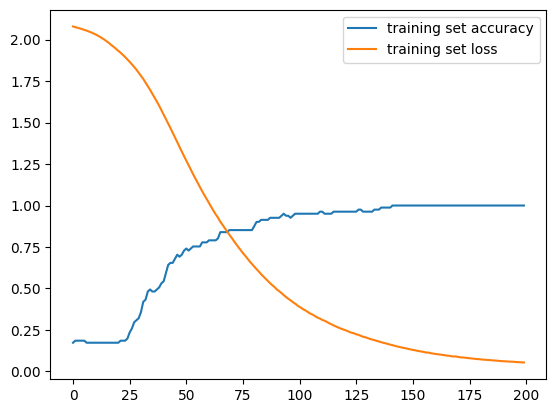

In [29]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()


# **Final Chatbot**

In [30]:
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : Hello
1/1 [==============================] - 0s 347ms/step
Going Merry :  Ha , Glad you showed up. How are you ?
You : Fine, thank you
1/1 [==============================] - 0s 20ms/step
Going Merry :  nice conversation. bye
